In [33]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler


In [51]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Load data

In [24]:
train_path = 'data/train.txt'
df = pd.read_csv(train_path)
df = df.drop(columns='0')
df.columns = ['AGE', 'WORKCLASS', 'EDUCATION', 'EDUCATIONAL-NUM', 'MARITAL-STATUS', 'OCCUPATION', 'RELATIONSHIP', 'GENDER', 'CAPITAL-GAIN', 'CAPITAL-LOSS', 'HOURS-PER-WEEK', 'INCOME']

In [25]:
df.head()

,AGE,WORKCLASS,EDUCATION,EDUCATIONAL-NUM,MARITAL-STATUS,OCCUPATION,RELATIONSHIP,GENDER,CAPITAL-GAIN,CAPITAL-LOSS,HOURS-PER-WEEK,INCOME
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Male,0,0,40,0
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,Male,0,0,50,0
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,Male,0,0,40,1
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Male,7688,0,40,1
4,18,?,Some-college,10,Never-married,?,Own-child,Female,0,0,30,0


# EDA

In [26]:
df.describe()

,AGE,EDUCATIONAL-NUM,CAPITAL-GAIN,CAPITAL-LOSS,HOURS-PER-WEEK,INCOME
count,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,38.64420,10.078967,1073.053400,87.860600,40.444667,0.237667
std,13.74484,2.560407,7467.692711,402.574338,12.389786,0.425661
min,17.00000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.00000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.00000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.00000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.00000,16.000000,99999.000000,4356.000000,99.000000,1.000000


<Figure size 1200x800 with 0 Axes>

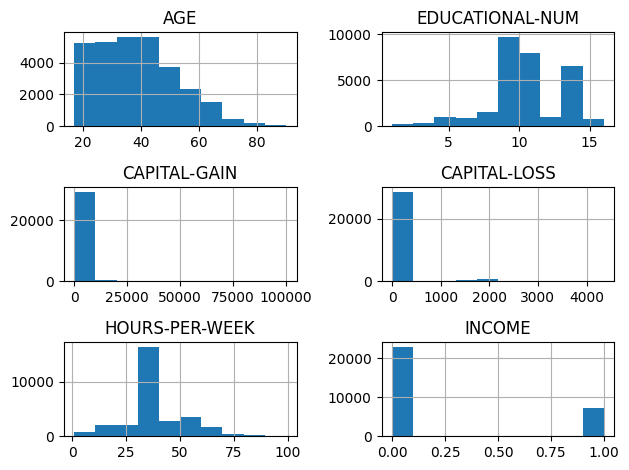

In [27]:
# Visualize distributions
plt.figure(figsize=(12,8))
df.hist()
plt.tight_layout()
plt.show()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   AGE              30000 non-null  int64 
 1   WORKCLASS        30000 non-null  object
 2   EDUCATION        30000 non-null  object
 3   EDUCATIONAL-NUM  30000 non-null  int64 
 4   MARITAL-STATUS   30000 non-null  object
 5   OCCUPATION       30000 non-null  object
 6   RELATIONSHIP     30000 non-null  object
 7   GENDER           30000 non-null  object
 8   CAPITAL-GAIN     30000 non-null  int64 
 9   CAPITAL-LOSS     30000 non-null  int64 
 10  HOURS-PER-WEEK   30000 non-null  int64 
 11  INCOME           30000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 2.7+ MB


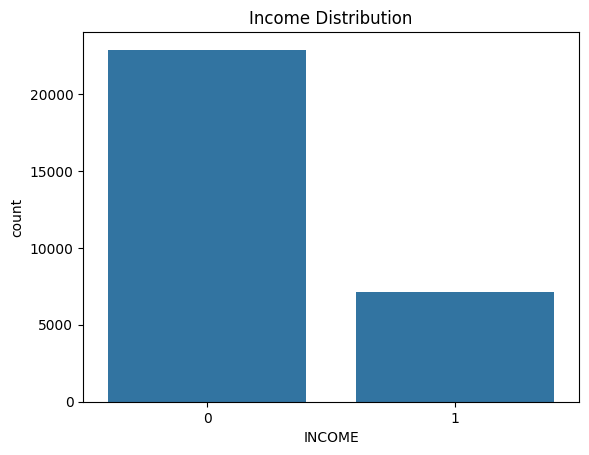

In [30]:
# Distribution of the 'income' column
sns.countplot(x='INCOME', data=df)
plt.title('Income Distribution')
plt.show()

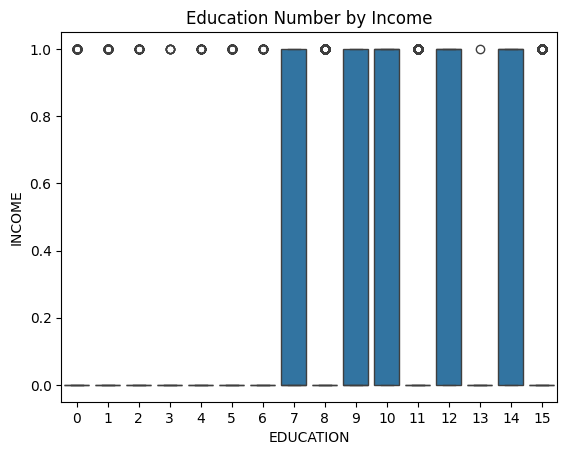

In [41]:
# Box plots for 'education' and 'income'
sns.boxplot(x='EDUCATION', y='INCOME', data=df)
plt.title('Education Number by Income')
plt.show()

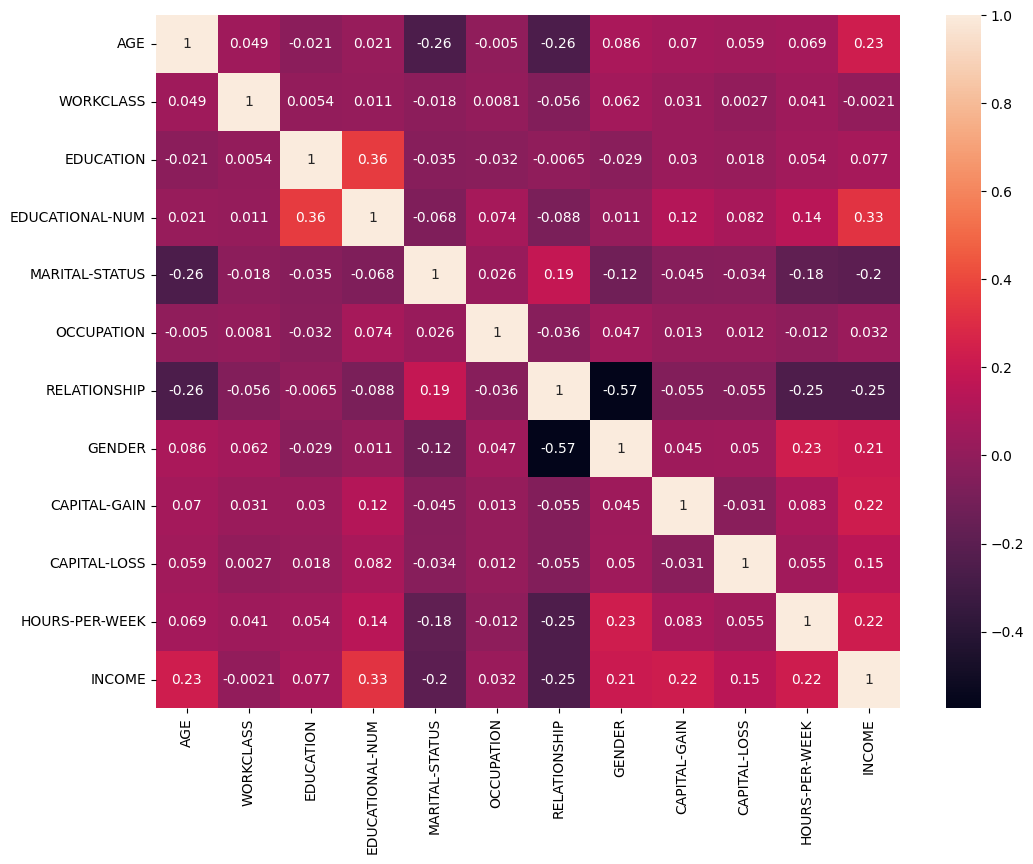

In [57]:
# Correlation matrix heatmap
non_object_columns = df.select_dtypes(exclude=['object'])
plt.subplots(figsize=(12,9))
sns.heatmap(non_object_columns.corr(), annot=True)
plt.show()

## Cleaning

In [35]:
# Number of missing values in each column of training data
missing_val = (df == '?').sum()

# Replace '?' with NaN (Not a Number)
df.replace('?', np.nan, inplace=True)

print("Missing values in data :")
print(missing_val[missing_val > 0])

Missing values in data :
WORKCLASS     1750
OCCUPATION    1755
dtype: int64


In [36]:
# Identifying numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Identifying categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: Index(['AGE', 'EDUCATIONAL-NUM', 'CAPITAL-GAIN', 'CAPITAL-LOSS',
       'HOURS-PER-WEEK', 'INCOME'],
      dtype='object')
Categorical Columns: Index(['WORKCLASS', 'EDUCATION', 'MARITAL-STATUS', 'OCCUPATION',
       'RELATIONSHIP', 'GENDER'],
      dtype='object')


In [37]:
# Imputer for numerical data - fill missing value
num_imputer = SimpleImputer(strategy='median')
# Imputer for categorical data
cat_imputer = SimpleImputer(strategy='most_frequent')

# Impute numerical columns
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# Impute categorical columns
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

In [40]:
label_encoder = LabelEncoder()
for i in categorical_cols:
    df[i] = label_encoder.fit_transform(df[i])
df.head()

,AGE,WORKCLASS,EDUCATION,EDUCATIONAL-NUM,MARITAL-STATUS,OCCUPATION,RELATIONSHIP,GENDER,CAPITAL-GAIN,CAPITAL-LOSS,HOURS-PER-WEEK,INCOME
0,25.0,3,1,7.0,4,6,3,1,0.0,0.0,40.0,0.0
1,38.0,3,11,9.0,2,4,0,1,0.0,0.0,50.0,0.0
2,28.0,1,7,12.0,2,10,0,1,0.0,0.0,40.0,1.0
3,44.0,3,15,10.0,2,6,0,1,7688.0,0.0,40.0,1.0
4,18.0,3,15,10.0,4,9,3,0,0.0,0.0,30.0,0.0


In [62]:
def preprocessing(df: pd.DataFrame, num_imputer: SimpleImputer, cat_imputer: SimpleImputer, label_encoder: LabelEncoder):
    df.replace('?', np.nan, inplace=True)
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    df[numerical_cols] = num_imputer.transform(df[numerical_cols])
    df[categorical_cols] = cat_imputer.transform(df[categorical_cols])
    for i in categorical_cols:
        df[i] = label_encoder.transform(df[i])
    return df

## TRAIN

In [44]:
y = df['INCOME'].values
X = df.drop('INCOME', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)


In [45]:
st =MinMaxScaler()
X_train = st.fit_transform(X_train)
X_test = st.fit_transform(X_test)

In [52]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy")


Base Models....


/Users/kiennguyen/interview/tpbank/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kiennguyen/interview/tpbank/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

accuracy: 0.8041 (LR) 
accuracy: 0.8373 (KNN) 
accuracy: 0.8033 (SVC) 
accuracy: 0.8111 (CART) 
accuracy: 0.8459 (RF) 
accuracy: 0.8578 (Adaboost) 
accuracy: 0.8643 (GBM) 
accuracy: 0.8661 (XGBoost) 
accuracy: 0.8702 (CatBoost) 


In [65]:
rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

adaboost_params = {"n_estimator" : [20, 50, 100],
                   "learning_rate" : [0.8, 1.0, 1.7]}

catboost_params = {
        "iterations": [100, 200],
        "learning_rate": [0.1, 0.01],
        "depth": [3, 4]
    }

classifiers = [('RF', RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('CatBoost', CatBoostClassifier(), catboost_params)]

def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X_train, y_train, scoring='accuracy')


Hyperparameter Optimization....
########## RF ##########
accuracy (Before): 0.8473


/Users/kiennguyen/interview/tpbank/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
31 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kiennguyen/interview/tpbank/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kiennguyen/interview/tpbank/.venv/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/kiennguyen/interview/tpbank/.venv/lib/python3.8/site-packages/sklearn/base.py", line 638, in

accuracy (After): 0.8633
RF best params: {'max_depth': 15, 'max_features': 5, 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost ##########
accuracy (Before): 0.8701
accuracy (After): 0.8718
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

########## CatBoost ##########
Learning rate set to 0.035394
0:	learn: 0.6569797	total: 7.25ms	remaining: 7.25s
1:	learn: 0.6236271	total: 11.3ms	remaining: 5.64s
2:	learn: 0.5962579	total: 15.2ms	remaining: 5.05s
3:	learn: 0.5684715	total: 19ms	remaining: 4.72s
4:	learn: 0.5473903	total: 22.6ms	remaining: 4.51s
5:	learn: 0.5273797	total: 26.5ms	remaining: 4.38s
6:	learn: 0.5105938	total: 30.4ms	remaining: 4.32s
7:	learn: 0.4946210	total: 34.5ms	remaining: 4.28s
8:	learn: 0.4801277	total: 38.4ms	remaining: 4.23s
9:	learn: 0.4660361	total: 41.9ms	remaining: 4.15s
10:	learn: 0.4530054	total: 45.8ms	remaining: 4.12s
11:	learn: 0.4415638	total: 49.6ms	remaining: 4.09s
12:	learn: 0.4319249	total: 53.4ms	rema

## TESTING

In [66]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('RF', best_models["RF"]),
                                              ('XGBoost', best_models["XGBoost"]),
                                              ('CatBoost', best_models["CatBoost"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

voting_clf = voting_classifier(best_models, X_test, y_test)
voting_clf

Voting Classifier...
0:	learn: 0.6195334	total: 3.08ms	remaining: 613ms
1:	learn: 0.5582386	total: 5.39ms	remaining: 534ms
2:	learn: 0.5241628	total: 6.96ms	remaining: 457ms
3:	learn: 0.4872596	total: 8.06ms	remaining: 395ms
4:	learn: 0.4694281	total: 9.49ms	remaining: 370ms
5:	learn: 0.4518973	total: 10.7ms	remaining: 345ms
6:	learn: 0.4318072	total: 65.4ms	remaining: 1.8s
7:	learn: 0.4138062	total: 75.1ms	remaining: 1.8s
8:	learn: 0.4020738	total: 76.4ms	remaining: 1.62s
9:	learn: 0.3919050	total: 77.6ms	remaining: 1.47s
10:	learn: 0.3841566	total: 80.5ms	remaining: 1.38s
11:	learn: 0.3782370	total: 81.8ms	remaining: 1.28s
12:	learn: 0.3718299	total: 83ms	remaining: 1.19s
13:	learn: 0.3683029	total: 84.1ms	remaining: 1.12s
14:	learn: 0.3629440	total: 85.2ms	remaining: 1.05s
15:	learn: 0.3596736	total: 86.7ms	remaining: 997ms
16:	learn: 0.3552781	total: 88ms	remaining: 947ms
17:	learn: 0.3512707	total: 89.1ms	remaining: 901ms
18:	learn: 0.3485109	total: 90.6ms	remaining: 863ms
19:	lea

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(max_depth=15,
                                                     max_features=5,
                                                     min_samples_split=15,
                                                     n_estimators=200)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            fe...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x13cc60730>)],
                 voting='soft')